# NN by pytorch

In [24]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

In [26]:
# specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [27]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


## Data Loading

In [12]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/NN_tuned_nonorm")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import dict_act, NN, train_NN, count_parameters

saved in: c:\Users\xinch\Desktop\RBI\models\NN_tuned_nonorm


## Data Extraction

In [8]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [9]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 242)
(411257,)
(102815, 242)
(102815,)


### Normalization

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X)
X_train_scaled = X_scaled[idx_train]
X_test_scaled = X_scaled[idx_test]
X_TEST_scaled = scaler.transform(X_TEST)

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 242)
(411257, 1)
(102815, 242)
(102815, 1)
(20135, 242)
(20135, 1)


## NN with tanh

### Init

In [15]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "tanh",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8321


In [16]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [17]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [18]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [19]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1050.05, test loss : 1028.12, TEST loss : 1023.19, lr: 0.0010
epoch : 10, train loss : 633.81, test loss : 615.54, TEST loss : 610.96, lr: 0.0010
epoch : 20, train loss : 298.37, test loss : 284.04, TEST loss : 280.59, lr: 0.0010
epoch : 30, train loss : 64.66, test loss : 56.02, TEST loss : 54.88, lr: 0.0010
epoch : 40, train loss : 4.46, test loss : 4.39, TEST loss : 11.52, lr: 0.0010
epoch : 50, train loss : 3.39, test loss : 3.44, TEST loss : 10.58, lr: 0.0010
epoch : 60, train loss : 3.02, test loss : 2.88, TEST loss : 10.68, lr: 0.0010
epoch : 70, train loss : 2.88, test loss : 2.90, TEST loss : 10.22, lr: 0.0010
epoch : 80, train loss : 2.68, test loss : 2.78, TEST loss : 10.16, lr: 0.0010
epoch : 90, train loss : 2.58, test loss : 2.49, TEST loss : 9.84, lr: 0.0010
epoch : 100, train loss : 2.55, test loss : 2.44, TEST loss : 9.64, lr: 0.0010
epoch : 110, train loss : 2.44, test loss : 2.25, TEST loss : 9.31, lr: 0.0010
epoch : 120, train loss : 2.34, te

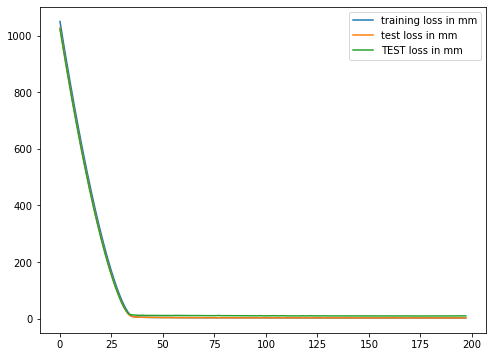

In [20]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [21]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [22]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

# RMSE_TEST_final_mm_last_2 = np.sqrt(mean_squared_error(y_TEST[-3487:], y_TEST_[-3487:]))
# RMSE_TEST_final_mm_rest = np.sqrt(mean_squared_error(y_TEST[:-3487], y_TEST_[:-3487]))
# print(f"TEST RMSE for the last 2 datasets: {RMSE_TEST_final_mm_last_2:.2f} mm")
# print(f"TEST RMSE for the rest datasets: {RMSE_TEST_final_mm_rest:.2f} mm")


train RMSE: 1.85 mm
test RMSE: 1.96 mm
TEST RMSE: 9.03 mm


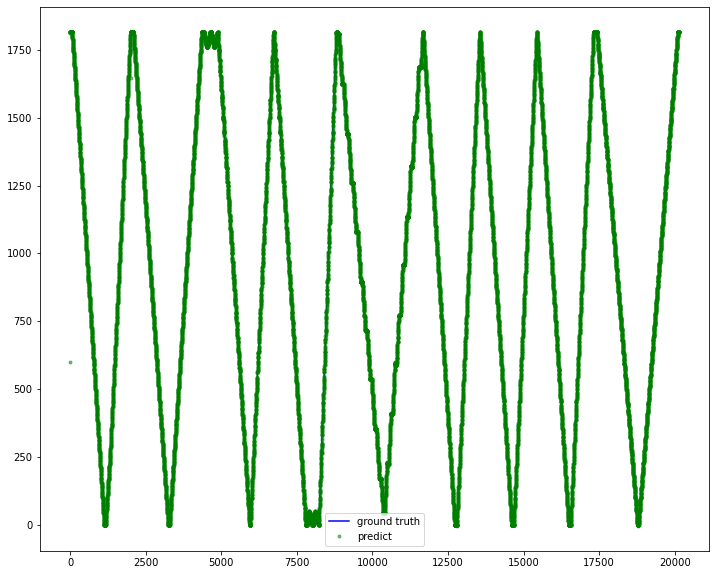

In [23]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


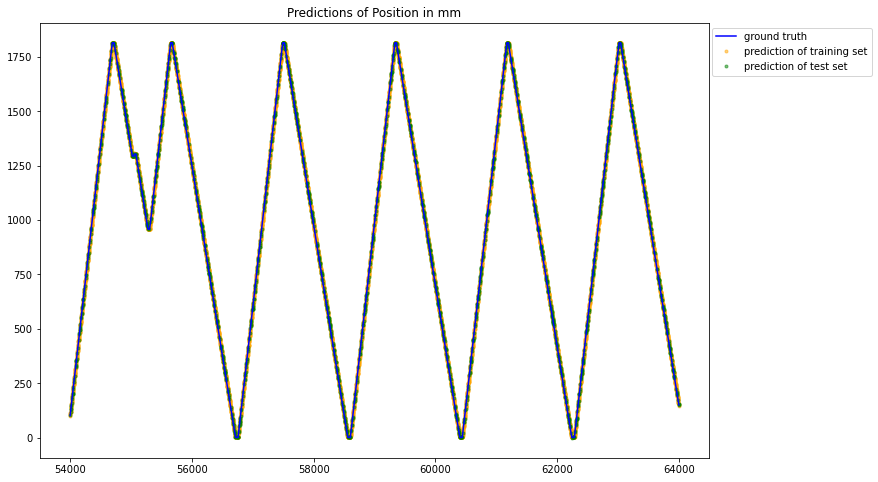

In [24]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with sigmoid

### Init

In [25]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
    
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_sigmoid.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_sigmoid.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8321


In [26]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [27]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [28]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [29]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1059.27, test loss : 1042.43, TEST loss : 1037.55, lr: 0.0010
epoch : 10, train loss : 731.77, test loss : 717.31, TEST loss : 712.51, lr: 0.0010
epoch : 20, train loss : 449.76, test loss : 437.30, TEST loss : 433.17, lr: 0.0010
epoch : 30, train loss : 219.50, test loss : 209.51, TEST loss : 206.43, lr: 0.0010
epoch : 40, train loss : 55.25, test loss : 48.92, TEST loss : 47.55, lr: 0.0010
epoch : 50, train loss : 5.85, test loss : 5.50, TEST loss : 8.96, lr: 0.0010
epoch : 60, train loss : 4.32, test loss : 4.36, TEST loss : 7.88, lr: 0.0010
epoch : 70, train loss : 3.74, test loss : 4.22, TEST loss : 7.43, lr: 0.0010
epoch : 80, train loss : 3.42, test loss : 3.44, TEST loss : 6.60, lr: 0.0010
epoch : 90, train loss : 3.17, test loss : 3.74, TEST loss : 6.45, lr: 0.0010
epoch : 100, train loss : 2.96, test loss : 3.11, TEST loss : 5.82, lr: 0.0010
epoch : 110, train loss : 2.80, test loss : 3.16, TEST loss : 5.84, lr: 0.0010
epoch : 120, train loss : 2.63, t

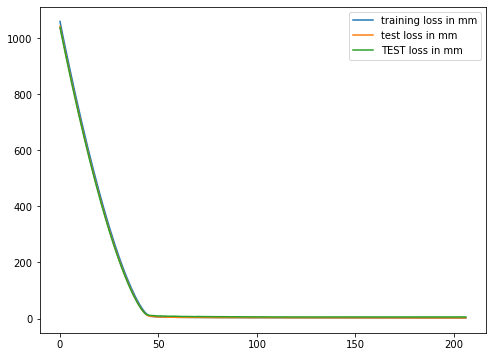

In [30]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [31]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [32]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

train RMSE: 1.99 mm
test RMSE: 2.12 mm
TEST RMSE: 5.66 mm


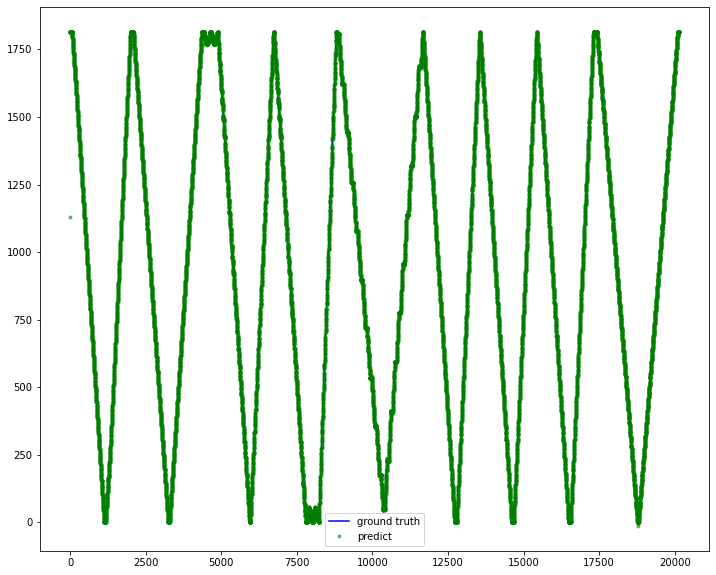

In [33]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


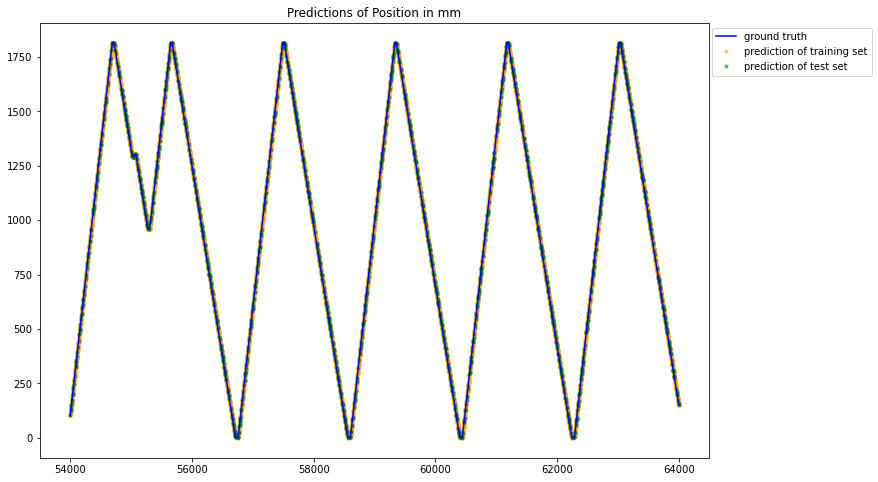

In [34]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with SeLU

### Init

In [35]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "selu",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_selu.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_selu.pth
NN(
  (activation): SELU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): SELU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): SELU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8321


In [36]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [37]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [38]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [39]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 378.62, test loss : 52.44, TEST loss : 147.58, lr: 0.0010
epoch : 10, train loss : 7.65, test loss : 7.45, TEST loss : 16.37, lr: 0.0010
epoch : 20, train loss : 5.81, test loss : 6.04, TEST loss : 12.03, lr: 0.0010
epoch : 30, train loss : 4.99, test loss : 5.35, TEST loss : 12.37, lr: 0.0010
epoch : 40, train loss : 4.52, test loss : 4.66, TEST loss : 10.23, lr: 0.0010
epoch : 50, train loss : 4.18, test loss : 4.29, TEST loss : 9.71, lr: 0.0010
epoch : 60, train loss : 3.96, test loss : 4.06, TEST loss : 8.39, lr: 0.0010
epoch : 70, train loss : 3.80, test loss : 3.71, TEST loss : 8.18, lr: 0.0010
epoch : 80, train loss : 3.64, test loss : 3.55, TEST loss : 7.66, lr: 0.0010
epoch : 90, train loss : 3.54, test loss : 3.58, TEST loss : 7.03, lr: 0.0010
epoch : 100, train loss : 3.45, test loss : 3.59, TEST loss : 7.31, lr: 0.0010
epoch : 110, train loss : 3.34, test loss : 3.34, TEST loss : 7.26, lr: 0.0010
epoch : 120, train loss : 3.26, test loss : 3.10, TEST

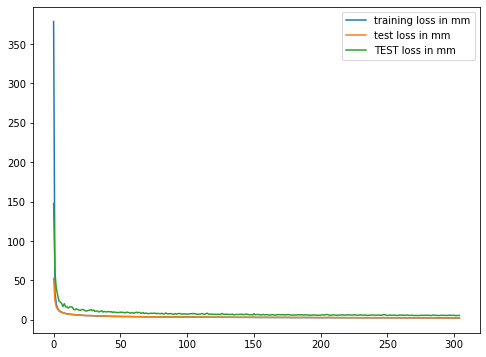

In [40]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [41]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.eval()


NN(
  (activation): SELU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): SELU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): SELU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [42]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 2.22 mm
test RMSE: 2.29 mm
TEST RMSE: 5.54 mm


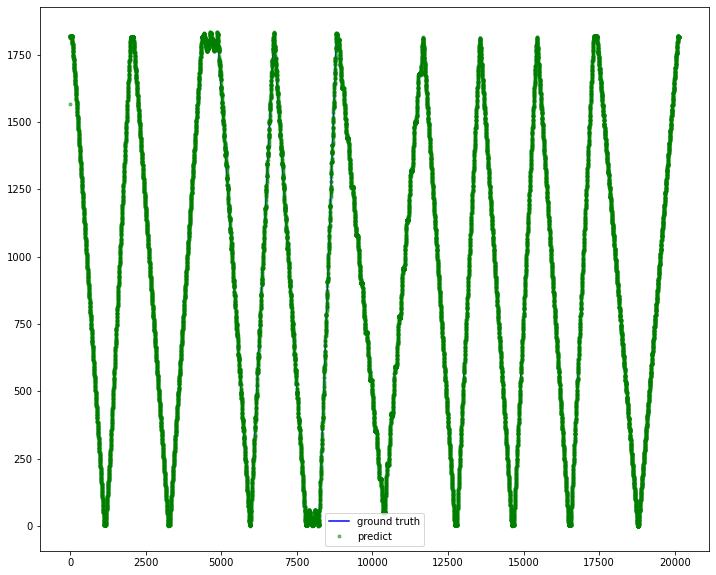

In [43]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


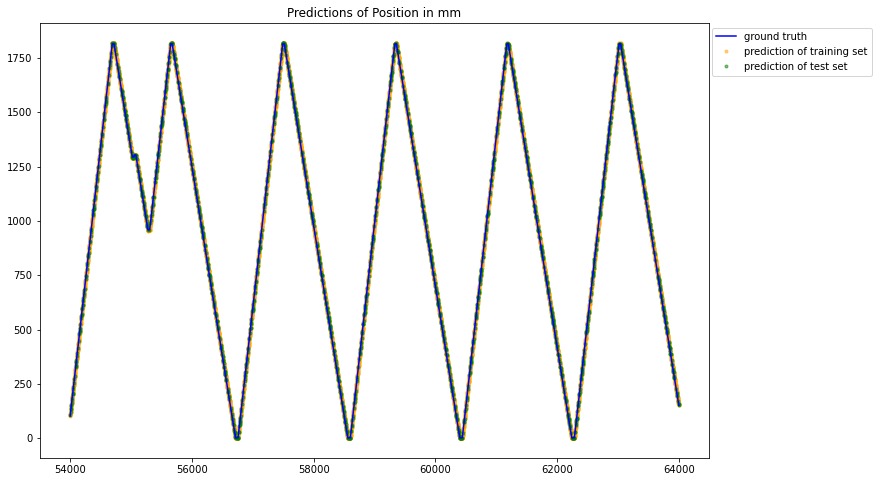

In [44]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with ReLU

### Init

In [45]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "relu",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_relu.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_relu.pth
NN(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8321


In [46]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [47]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [48]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [49]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 355.62, test loss : 35.47, TEST loss : 61.82, lr: 0.0010
epoch : 10, train loss : 7.50, test loss : 7.66, TEST loss : 16.37, lr: 0.0010
epoch : 20, train loss : 5.98, test loss : 6.01, TEST loss : 15.15, lr: 0.0010
epoch : 30, train loss : 5.37, test loss : 5.35, TEST loss : 13.23, lr: 0.0010
epoch : 40, train loss : 4.99, test loss : 5.12, TEST loss : 13.33, lr: 0.0010
epoch : 50, train loss : 4.76, test loss : 5.16, TEST loss : 11.30, lr: 0.0010
epoch : 60, train loss : 4.59, test loss : 4.60, TEST loss : 11.33, lr: 0.0010
epoch : 70, train loss : 4.45, test loss : 4.46, TEST loss : 10.15, lr: 0.0010
epoch : 80, train loss : 4.33, test loss : 4.44, TEST loss : 10.02, lr: 0.0010
epoch : 90, train loss : 4.22, test loss : 4.20, TEST loss : 10.66, lr: 0.0010
epoch : 100, train loss : 4.14, test loss : 4.33, TEST loss : 10.84, lr: 0.0010
epoch : 110, train loss : 4.06, test loss : 4.07, TEST loss : 9.35, lr: 0.0010
epoch : 120, train loss : 3.96, test loss : 4.06,

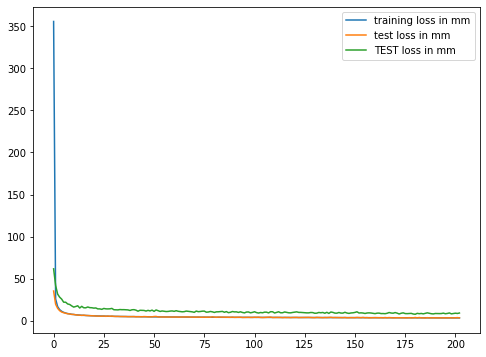

In [50]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [51]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.eval()


NN(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [52]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 3.36 mm
test RMSE: 3.44 mm
TEST RMSE: 8.92 mm


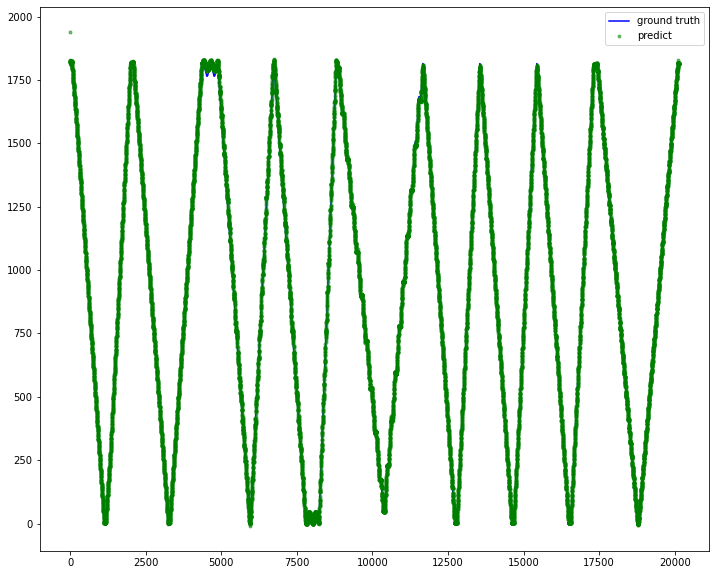

In [53]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


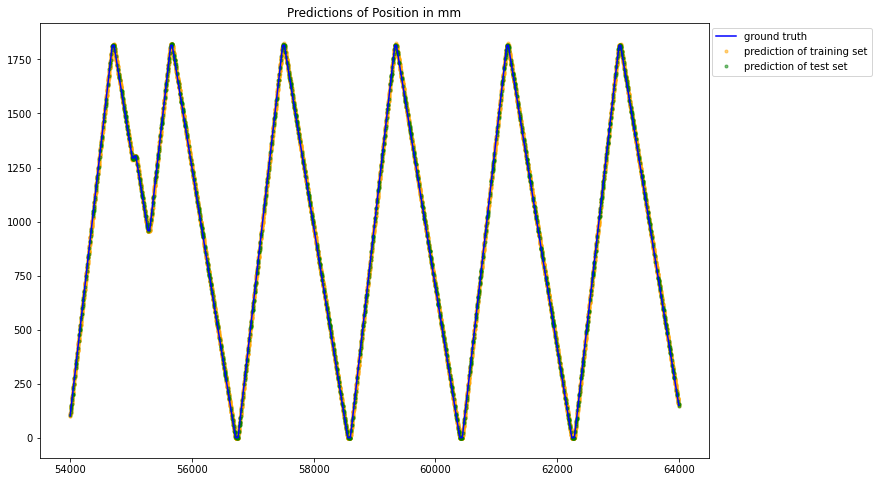

In [54]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with LeakyReLU(0.2)

### Init

In [55]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "tanh",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_leakyrelu.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_leakyrelu.pth
NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8321


In [56]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [57]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [58]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [59]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1050.23, test loss : 1028.29, TEST loss : 1023.36, lr: 0.0010
epoch : 10, train loss : 633.97, test loss : 615.72, TEST loss : 611.10, lr: 0.0010
epoch : 20, train loss : 298.41, test loss : 284.07, TEST loss : 280.64, lr: 0.0010
epoch : 30, train loss : 64.66, test loss : 56.06, TEST loss : 54.98, lr: 0.0010
epoch : 40, train loss : 3.96, test loss : 3.77, TEST loss : 11.66, lr: 0.0010
epoch : 50, train loss : 3.14, test loss : 3.15, TEST loss : 10.55, lr: 0.0010
epoch : 60, train loss : 2.80, test loss : 2.97, TEST loss : 11.02, lr: 0.0010
epoch : 70, train loss : 2.55, test loss : 2.60, TEST loss : 10.69, lr: 0.0010
epoch : 80, train loss : 2.35, test loss : 2.27, TEST loss : 10.75, lr: 0.0010
epoch : 90, train loss : 2.33, test loss : 2.17, TEST loss : 11.31, lr: 0.0010
epoch : 100, train loss : 2.24, test loss : 2.78, TEST loss : 11.07, lr: 0.0010
Early stopping triggered
The minimal test loss is 2.16 from epoch 85


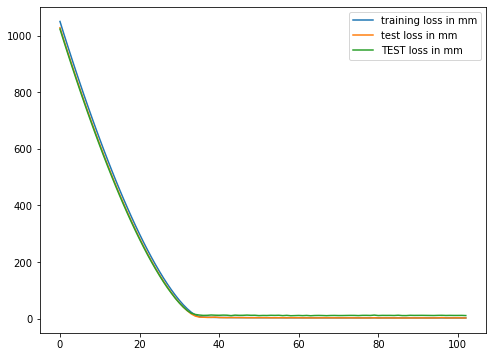

In [60]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [61]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.eval()


NN(
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [62]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 2.12 mm
test RMSE: 2.16 mm
TEST RMSE: 11.78 mm


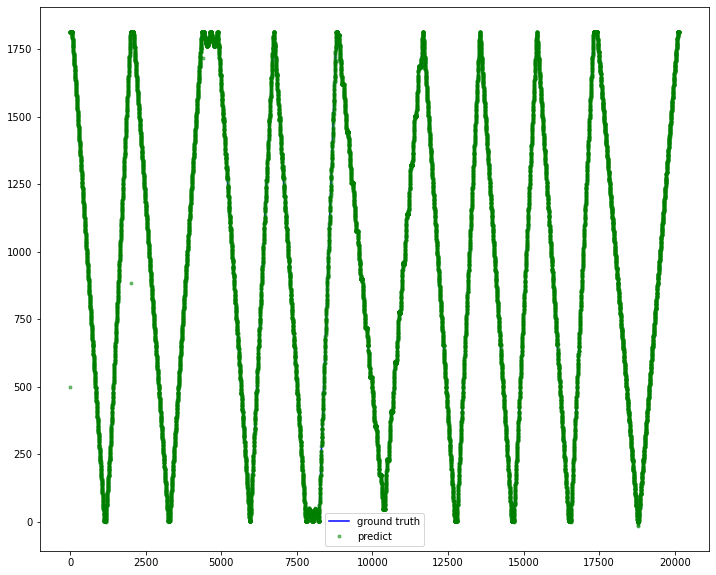

In [63]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


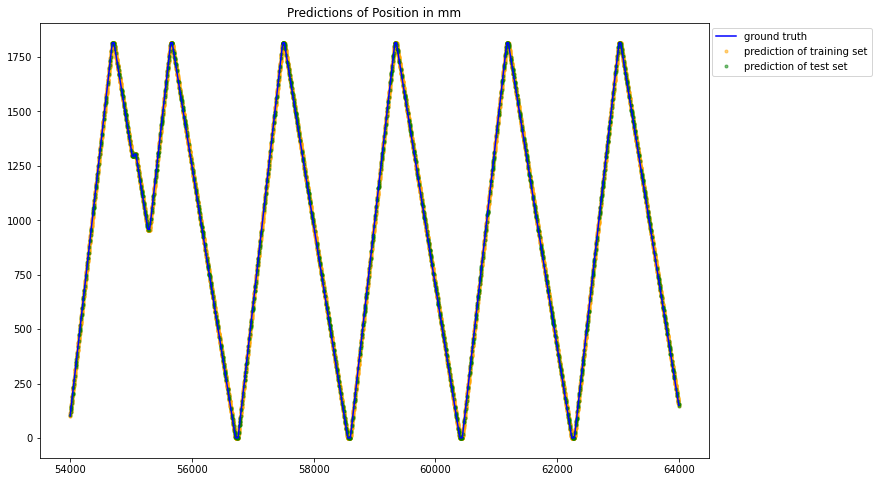

In [64]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## with sigmoid and CosineAnnealingWarmRestarts

### Init

In [65]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,  
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + "_sigmoid_cos.pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16_sigmoid_cos.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 8321


In [66]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [67]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult=2, eta_min=0, last_epoch=- 1, verbose=False)
loss_fn = nn.MSELoss()


In [68]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [69]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1061.43, test loss : 1044.09, TEST loss : 1039.21, lr: 0.0010
epoch : 10, train loss : 874.35, test loss : 859.00, TEST loss : 854.07, lr: 0.0010
epoch : 20, train loss : 622.62, test loss : 616.03, TEST loss : 611.42, lr: 0.0005
epoch : 30, train loss : 556.09, test loss : 542.76, TEST loss : 538.32, lr: 0.0010
epoch : 40, train loss : 315.31, test loss : 305.77, TEST loss : 302.20, lr: 0.0009
epoch : 50, train loss : 172.19, test loss : 167.46, TEST loss : 164.72, lr: 0.0005
epoch : 60, train loss : 116.37, test loss : 115.02, TEST loss : 112.76, lr: 0.0001
epoch : 70, train loss : 100.22, test loss : 92.40, TEST loss : 90.40, lr: 0.0010
epoch : 80, train loss : 7.61, test loss : 7.14, TEST loss : 10.96, lr: 0.0010
epoch : 90, train loss : 4.88, test loss : 4.78, TEST loss : 9.13, lr: 0.0009
epoch : 100, train loss : 4.00, test loss : 4.33, TEST loss : 8.40, lr: 0.0007
epoch : 110, train loss : 3.43, test loss : 3.55, TEST loss : 7.69, lr: 0.0005
epoch : 120, 

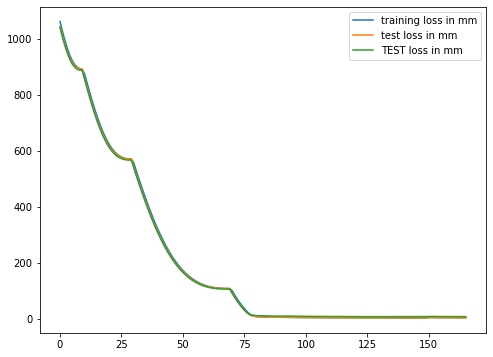

In [70]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [71]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [72]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")

train RMSE: 2.58 mm
test RMSE: 2.91 mm
TEST RMSE: 7.10 mm


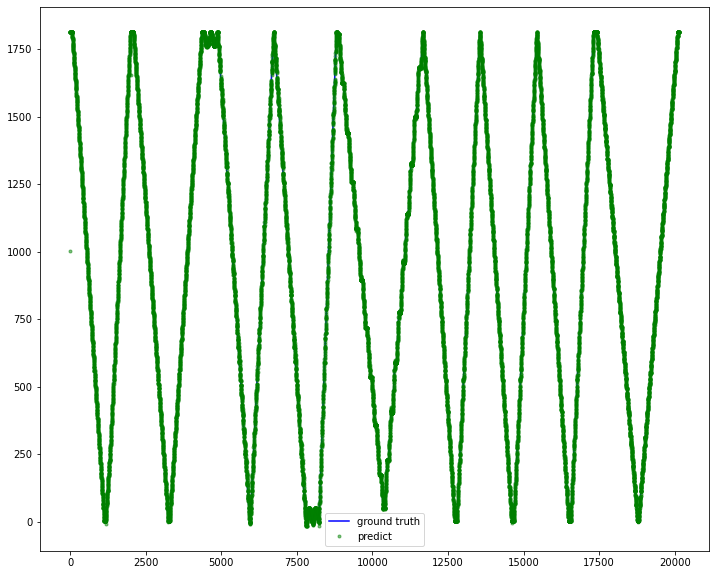

In [73]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


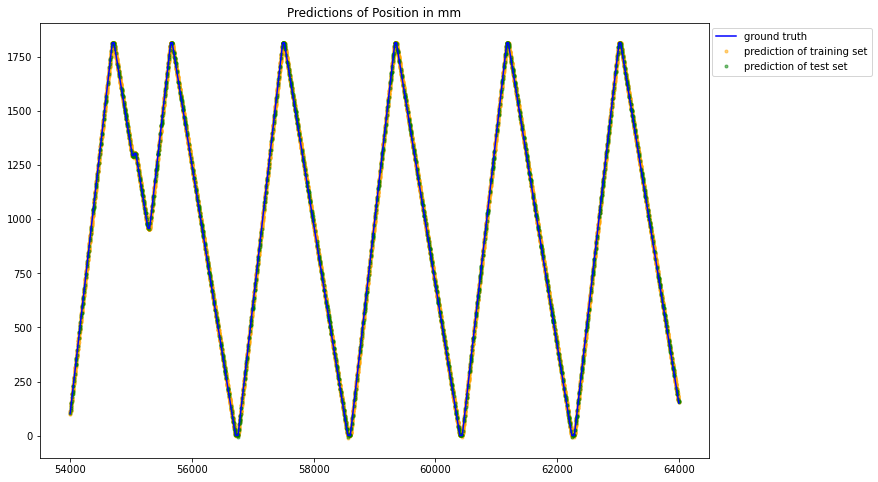

In [74]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 1 layer

### Init

In [75]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
number of learning parameters: 7809


In [76]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [77]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )

model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [78]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [79]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1030.08, test loss : 984.73, TEST loss : 979.85, lr: 0.0010
epoch : 10, train loss : 319.10, test loss : 293.00, TEST loss : 290.30, lr: 0.0010
epoch : 20, train loss : 91.73, test loss : 90.17, TEST loss : 94.88, lr: 0.0010
epoch : 30, train loss : 66.52, test loss : 66.07, TEST loss : 71.23, lr: 0.0010
epoch : 40, train loss : 47.46, test loss : 47.34, TEST loss : 51.99, lr: 0.0010
epoch : 50, train loss : 35.26, test loss : 35.25, TEST loss : 40.58, lr: 0.0010
epoch : 60, train loss : 26.90, test loss : 27.13, TEST loss : 32.25, lr: 0.0010
epoch : 70, train loss : 22.59, test loss : 22.97, TEST loss : 28.34, lr: 0.0010
epoch : 80, train loss : 20.57, test loss : 20.87, TEST loss : 26.73, lr: 0.0010
epoch : 90, train loss : 19.41, test loss : 19.75, TEST loss : 25.81, lr: 0.0010
epoch : 100, train loss : 18.58, test loss : 18.93, TEST loss : 25.34, lr: 0.0010
epoch : 110, train loss : 17.96, test loss : 18.37, TEST loss : 24.60, lr: 0.0010
epoch : 120, train l

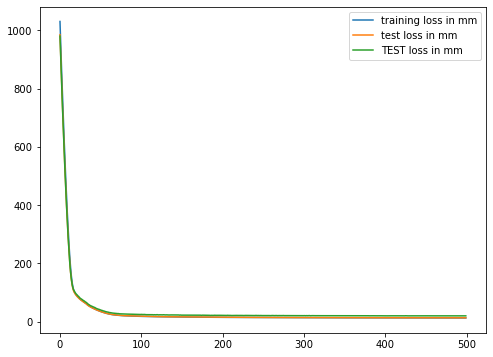

In [80]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [81]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [82]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 13.09 mm
test RMSE: 13.67 mm
TEST RMSE: 20.37 mm


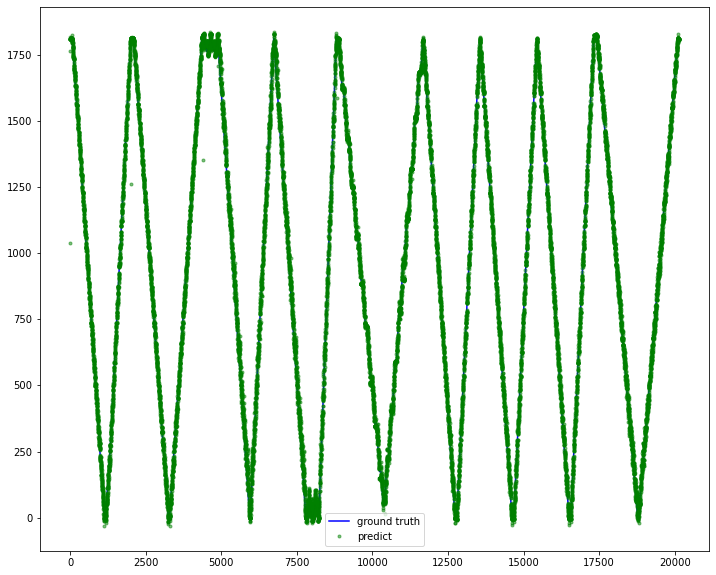

In [83]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


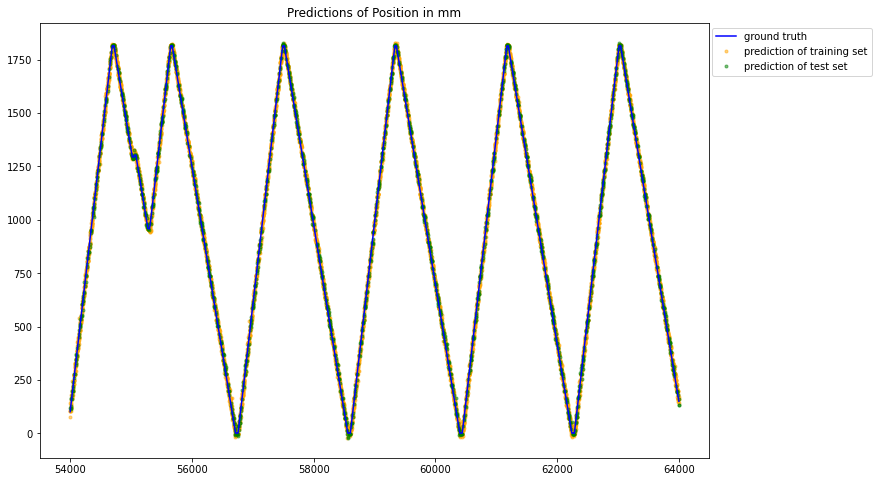

In [84]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 3 layer

### Init

In [95]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 9377


In [96]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [97]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [98]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [99]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1061.55, test loss : 1046.88, TEST loss : 1041.99, lr: 0.0010
epoch : 10, train loss : 716.49, test loss : 700.96, TEST loss : 696.20, lr: 0.0010
epoch : 20, train loss : 417.72, test loss : 404.57, TEST loss : 400.61, lr: 0.0010
epoch : 30, train loss : 180.36, test loss : 170.22, TEST loss : 167.47, lr: 0.0010
epoch : 40, train loss : 24.33, test loss : 19.06, TEST loss : 20.20, lr: 0.0010
epoch : 50, train loss : 1.35, test loss : 1.24, TEST loss : 10.08, lr: 0.0010
epoch : 60, train loss : 1.08, test loss : 0.97, TEST loss : 10.43, lr: 0.0010
epoch : 70, train loss : 0.93, test loss : 0.97, TEST loss : 10.34, lr: 0.0010
epoch : 80, train loss : 0.84, test loss : 0.86, TEST loss : 10.30, lr: 0.0010
epoch : 90, train loss : 0.77, test loss : 0.83, TEST loss : 10.27, lr: 0.0010
epoch : 100, train loss : 0.73, test loss : 0.74, TEST loss : 10.32, lr: 0.0010
epoch : 110, train loss : 0.70, test loss : 0.66, TEST loss : 10.17, lr: 0.0010
epoch : 120, train loss : 

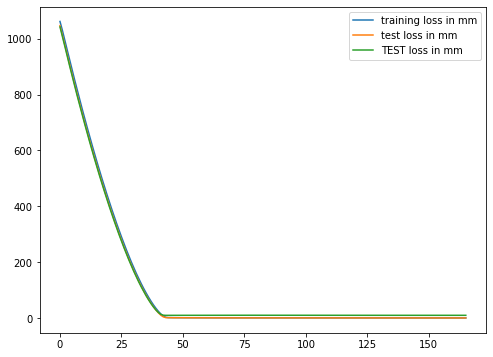

In [100]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [101]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [102]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.54 mm
test RMSE: 0.55 mm
TEST RMSE: 10.08 mm


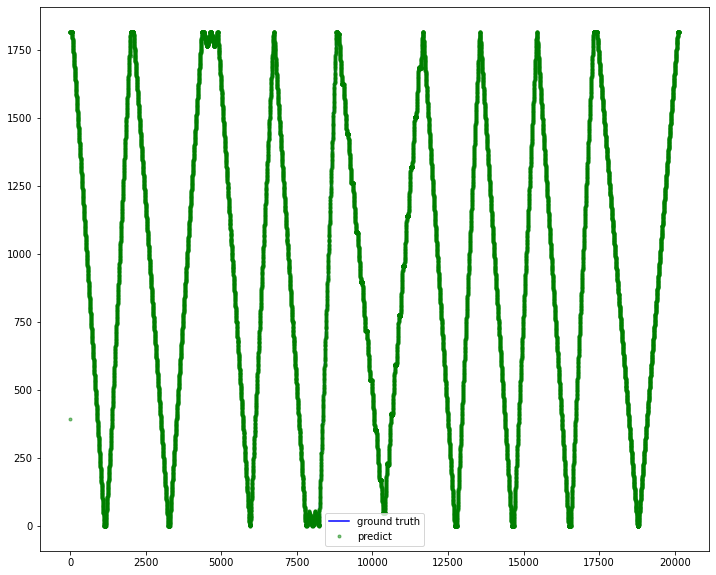

In [103]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


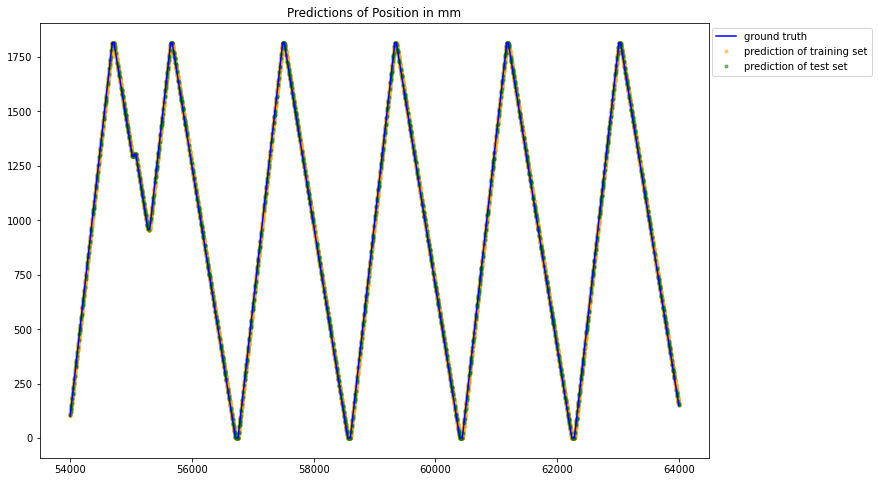

In [104]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 4 layer

### Init

In [115]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 10433


In [116]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [117]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [118]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [119]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1060.07, test loss : 1044.90, TEST loss : 1040.01, lr: 0.0010
epoch : 10, train loss : 716.87, test loss : 701.34, TEST loss : 696.57, lr: 0.0010
epoch : 20, train loss : 418.04, test loss : 404.88, TEST loss : 400.84, lr: 0.0010
epoch : 30, train loss : 180.60, test loss : 170.45, TEST loss : 167.59, lr: 0.0010
epoch : 40, train loss : 24.52, test loss : 19.22, TEST loss : 19.12, lr: 0.0010
epoch : 50, train loss : 1.73, test loss : 2.05, TEST loss : 8.55, lr: 0.0010
epoch : 60, train loss : 1.44, test loss : 1.51, TEST loss : 8.70, lr: 0.0010
epoch : 70, train loss : 1.27, test loss : 1.23, TEST loss : 8.81, lr: 0.0010
epoch : 80, train loss : 1.15, test loss : 1.02, TEST loss : 9.03, lr: 0.0010
epoch : 90, train loss : 1.05, test loss : 0.95, TEST loss : 8.94, lr: 0.0010
epoch : 100, train loss : 0.99, test loss : 0.80, TEST loss : 8.90, lr: 0.0010
epoch : 110, train loss : 0.92, test loss : 0.93, TEST loss : 8.91, lr: 0.0010
epoch : 120, train loss : 0.87, t

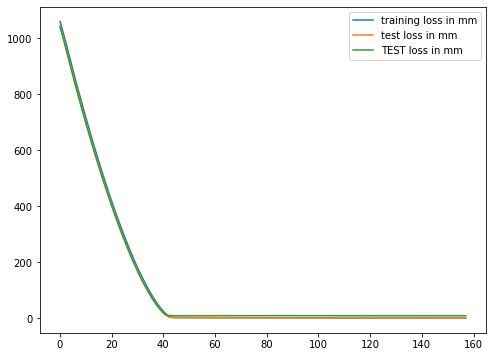

In [120]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [121]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [122]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.70 mm
test RMSE: 0.72 mm
TEST RMSE: 8.74 mm


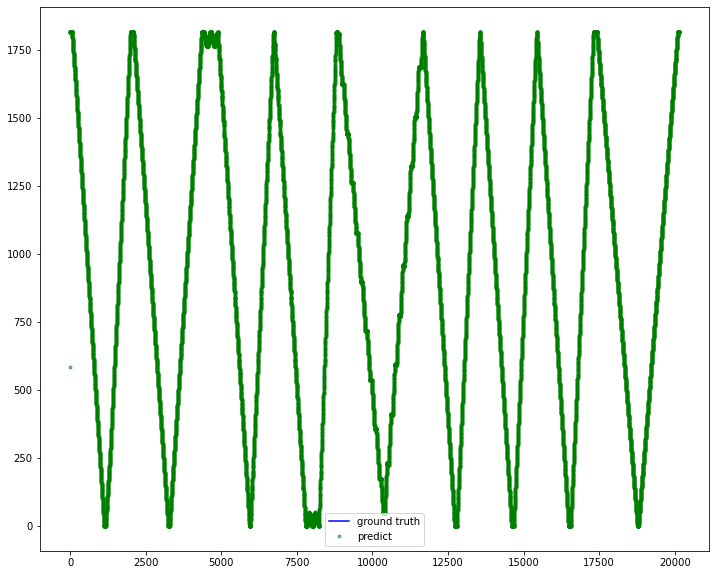

In [123]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


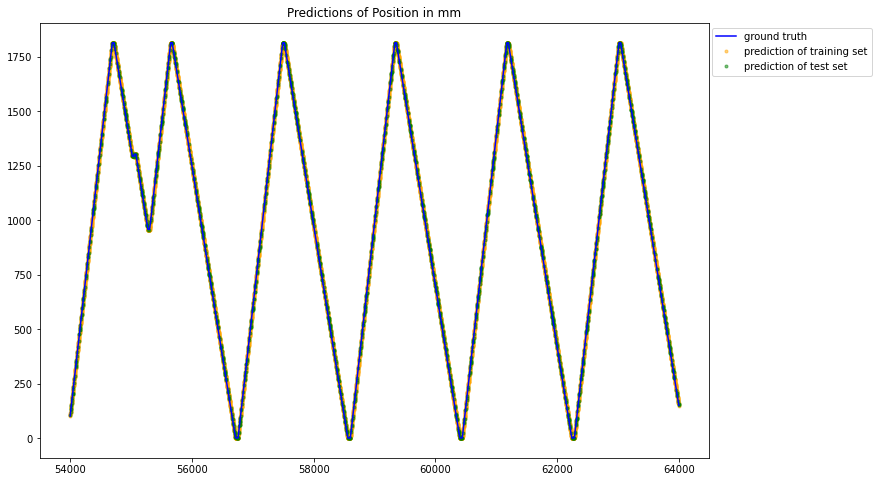

In [124]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 5 layer

### Init

In [25]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 11489


In [26]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [27]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [28]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [29]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1059.14, test loss : 1042.49, TEST loss : 1037.60, lr: 0.0010
epoch : 10, train loss : 712.53, test loss : 697.78, TEST loss : 692.07, lr: 0.0010
epoch : 20, train loss : 342.34, test loss : 327.39, TEST loss : 323.58, lr: 0.0010
epoch : 30, train loss : 93.62, test loss : 84.29, TEST loss : 81.51, lr: 0.0010
epoch : 40, train loss : 20.03, test loss : 19.77, TEST loss : 18.06, lr: 0.0010
epoch : 50, train loss : 12.29, test loss : 11.93, TEST loss : 11.92, lr: 0.0010
epoch : 60, train loss : 5.77, test loss : 5.41, TEST loss : 8.29, lr: 0.0010
epoch : 70, train loss : 1.89, test loss : 2.27, TEST loss : 7.25, lr: 0.0010
epoch : 80, train loss : 1.41, test loss : 1.11, TEST loss : 6.62, lr: 0.0010
epoch : 90, train loss : 1.30, test loss : 1.26, TEST loss : 6.94, lr: 0.0010
epoch : 100, train loss : 1.21, test loss : 1.42, TEST loss : 6.91, lr: 0.0010
epoch : 110, train loss : 1.08, test loss : 1.04, TEST loss : 6.81, lr: 0.0010
epoch : 120, train loss : 1.04, t

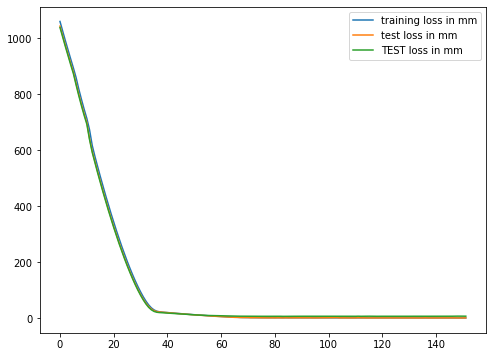

In [30]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [31]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [32]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.75 mm
test RMSE: 0.76 mm
TEST RMSE: 6.94 mm


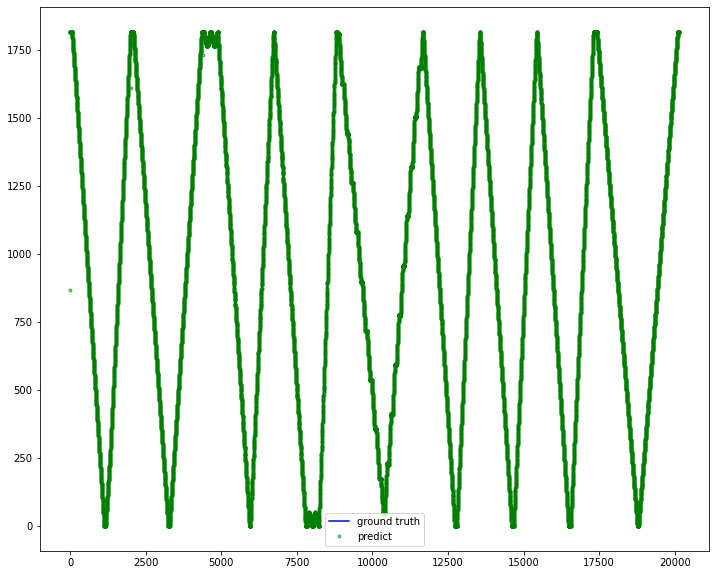

In [33]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


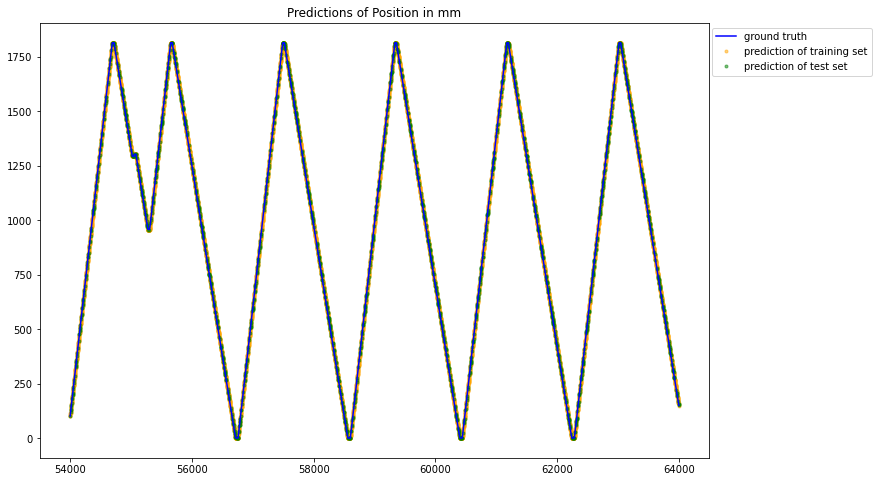

In [34]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 5 layer

### Init

In [165]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 11489


In [166]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [167]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [168]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [169]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1060.93, test loss : 1045.39, TEST loss : 1040.50, lr: 0.0010
epoch : 10, train loss : 705.00, test loss : 690.55, TEST loss : 684.82, lr: 0.0010
epoch : 20, train loss : 567.87, test loss : 567.99, TEST loss : 562.66, lr: 0.0010
epoch : 30, train loss : 176.49, test loss : 164.52, TEST loss : 161.38, lr: 0.0010
epoch : 40, train loss : 24.78, test loss : 23.57, TEST loss : 20.99, lr: 0.0010
epoch : 50, train loss : 15.38, test loss : 15.08, TEST loss : 13.23, lr: 0.0010
epoch : 60, train loss : 8.51, test loss : 8.19, TEST loss : 7.35, lr: 0.0010
epoch : 70, train loss : 3.72, test loss : 3.43, TEST loss : 4.10, lr: 0.0010
epoch : 80, train loss : 2.24, test loss : 1.87, TEST loss : 3.53, lr: 0.0010
epoch : 90, train loss : 1.94, test loss : 1.88, TEST loss : 3.86, lr: 0.0010
epoch : 100, train loss : 1.81, test loss : 1.77, TEST loss : 3.59, lr: 0.0010
epoch : 110, train loss : 1.67, test loss : 1.84, TEST loss : 3.62, lr: 0.0010
epoch : 120, train loss : 1.52

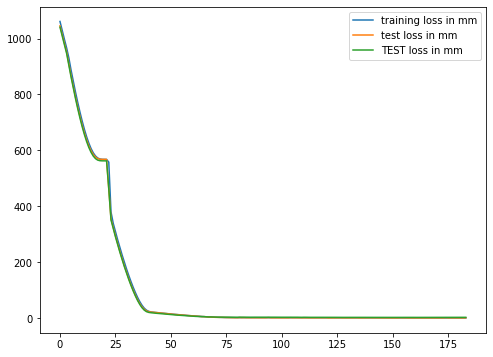

In [170]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [171]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [172]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.01 mm
test RMSE: 1.21 mm
TEST RMSE: 3.07 mm


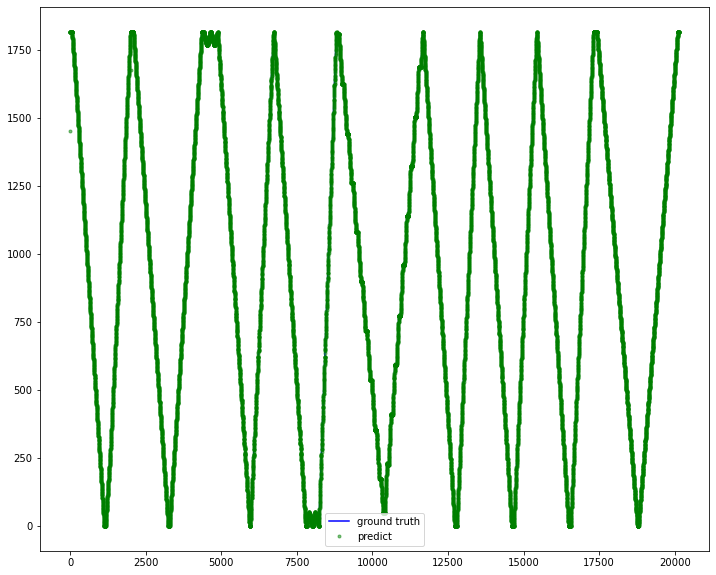

In [173]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


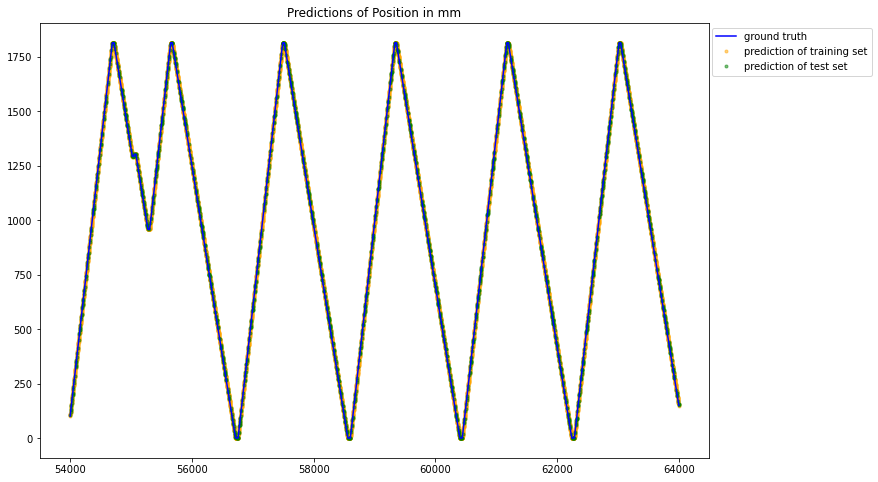

In [174]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 6 layer

### Init

In [155]:
# configuration
_config = {
    "n_features": 242,
    "list_hidden": [32, 32, 32, 32, 32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,
    "weight_decay": 1e-4,
    "betas": (0.9, 0.999),
    "use_dropout": False,
    "use_bn": False,
}

# dot access
config = dotdict(_config)

dict_act = {
    "sigmoid": nn.Sigmoid(),
    "selu": nn.SELU(),
    "relu": nn.ReLU(),
    "leakyrelu": nn.LeakyReLU(0.2),
    "tanh": nn.Tanh(),
}

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-32-32-32-32-16.pth
NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)
number of learning parameters: 12545


In [156]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [157]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [158]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [159]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1061.50, test loss : 1046.26, TEST loss : 1041.37, lr: 0.0010
epoch : 10, train loss : 720.48, test loss : 705.42, TEST loss : 699.73, lr: 0.0010
epoch : 20, train loss : 567.94, test loss : 568.02, TEST loss : 562.68, lr: 0.0010
epoch : 30, train loss : 567.83, test loss : 567.97, TEST loss : 562.66, lr: 0.0010
epoch : 40, train loss : 567.83, test loss : 567.97, TEST loss : 562.66, lr: 0.0010
epoch : 50, train loss : 181.47, test loss : 169.38, TEST loss : 166.18, lr: 0.0010
epoch : 60, train loss : 25.67, test loss : 24.27, TEST loss : 21.60, lr: 0.0010
epoch : 70, train loss : 15.83, test loss : 15.50, TEST loss : 13.66, lr: 0.0010
epoch : 80, train loss : 8.95, test loss : 8.77, TEST loss : 8.44, lr: 0.0010
epoch : 90, train loss : 4.14, test loss : 3.78, TEST loss : 5.53, lr: 0.0010
epoch : 100, train loss : 2.52, test loss : 3.04, TEST loss : 5.83, lr: 0.0010
epoch : 110, train loss : 2.18, test loss : 2.11, TEST loss : 5.64, lr: 0.0010
epoch : 120, train

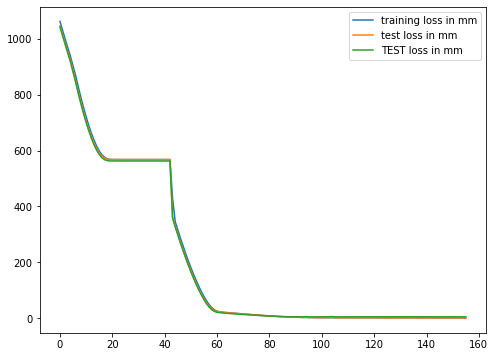

In [160]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [161]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=242, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): Sigmoid()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [162]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.Tensor(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.Tensor(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.43 mm
test RMSE: 1.45 mm
TEST RMSE: 5.73 mm


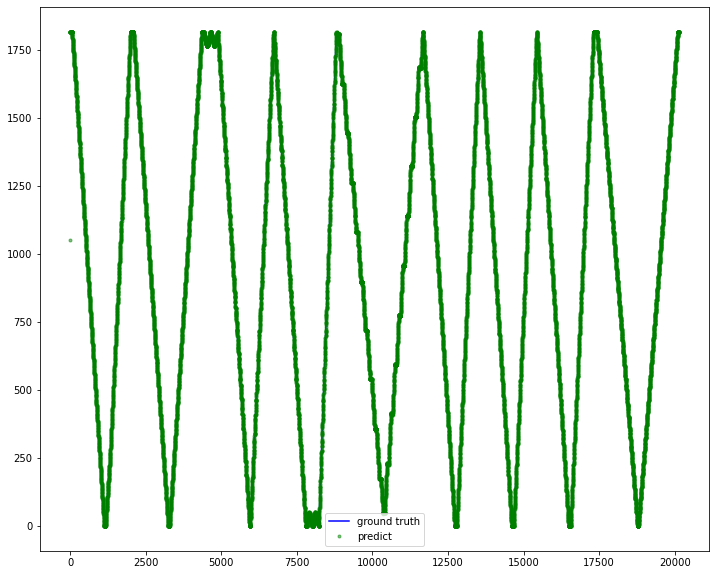

In [163]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


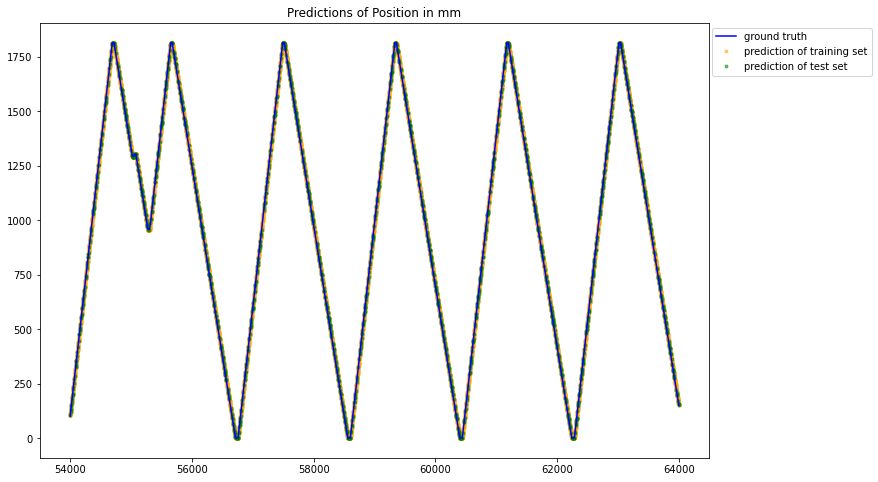

In [164]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
